In [4]:
import os # saving files
import numpy as np # for matrix math
from tqdm import tqdm # progress bar
import preprocessing
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from Dataset import AHBDataset
from torch.utils.data import DataLoader
import networks as net
import torch
import matplotlib.pyplot as plt
is_cuda = False
if torch.cuda.is_available():
    is_cuda = True

In [5]:
#读取数据
NiH = preprocessing.read_data('data/NiH_dataset.mat')
PdH = preprocessing.read_data('data/PdH_dataset.mat')
print(np.shape(NiH))
print(np.shape(PdH))

(35, 4)
(35, 4)


In [6]:
#获取每种元素的最大行数
max_PdH = preprocessing.compute_max(PdH)
max_NiH = preprocessing.compute_max(NiH)
max_len=max(max_PdH,max_NiH)
max_len

18

In [7]:
#做数据填充（0）
Ni_H = preprocessing.data_padding(NiH,max_len)
Pd_H = preprocessing.data_padding(PdH,max_len)
print(np.array(Ni_H).shape)
print(np.array(Pd_H).shape)

(35, 4, 18, 3)
(35, 4, 18, 3)


In [8]:
#定义超参数
n_epoch =100
batch_size  = 35
input_dim = 3
latent_dim = 3
eps_dim = 3

# 判别器
n_layer_disc = 5
n_hidden_disc = 100

# 生成器
n_layer_gen = 5
n_hidden_gen= 100

# 另一个生成器
n_layer_inf = 5
n_hidden_inf= 100

In [9]:
#创建结果文件夹
result_dir = 'STEP1+STEP2_CrsytalGAN/'
directory = result_dir
if not os.path.exists(directory):
    os.makedirs(directory)
# AH和BH的真实样本
# 在本例中是Pd_H和Ni_H
AH_dataset = Pd_H
BH_dataset = Ni_H
print(np.array(AH_dataset).shape)
print(np.array(BH_dataset).shape)

(35, 4, 18, 3)
(35, 4, 18, 3)


In [10]:
#定义数据集
from Dataset import AHBDataset
from torch.utils.data import DataLoader
dataSet=AHBDataset(AH_dataset,BH_dataset)
dataLoader=DataLoader(dataSet,batch_size=batch_size,shuffle=True)

In [11]:
#定义模型
GenAHB=net.Generator_AHB(input_dim,n_layer_gen,n_hidden_gen)
GenBHA=net.Generator_BHA(latent_dim,n_layer_inf,n_hidden_inf)
DisAH=net.Discriminator_AH(input_dim,n_layer_disc,n_hidden_disc)
DisBH=net.Discriminator_BH(input_dim,n_layer_disc,n_hidden_disc)
if is_cuda:
    GenAHB.cuda()
    GenBHA.cuda()
    DisAH.cuda()
    DisBH.cuda()
GenAHB.train()
GenBHA.train()
DisAH.train()
DisBH.train()

Discriminator_BH(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=100, bias=True)
    (full_layer1): Linear(in_features=100, out_features=100, bias=True)
    (relu1): ReLU()
    (full_layer2): Linear(in_features=100, out_features=100, bias=True)
    (relu2): ReLU()
    (full_layer3): Linear(in_features=100, out_features=100, bias=True)
    (relu3): ReLU()
    (full_layer4): Linear(in_features=100, out_features=100, bias=True)
    (relu4): ReLU()
    (output): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [12]:
#定义优化器
train_gen_op=optim.Adam(params=list(GenAHB.parameters())+list(GenBHA.parameters()),lr=1e-4,betas=[0.5,0.999])
train_disc_op=optim.Adam(params=list(DisAH.parameters())+list(DisBH.parameters()),lr=1e-4,betas=[0.5,0.999])

In [29]:
FG = []
FD = []
for epoch in range(n_epoch):
    print('----------epoch:{}----------'.format(epoch))
    for AH,BH in dataLoader:
        def getLoss(AH,BH):
            if is_cuda:
                AH,BH=AH.cuda(),BH.cuda()
            AH,BH=Variable(AH),Variable(BH)
            AHB=GenAHB(BH)
            BHA=GenBHA(AH)
            rec_AH=GenBHA(AHB)
            rec_BH=GenAHB(BHA)
            encoder_sigmoid_AH=DisBH(AH)
            decorator_sigmoid_AH=DisBH(AHB)
            encoder_sigmoid_BH=DisBH(BH)
            decorator_sigmoid_BH=DisBH(BHA)
            decoder_loss=decorator_sigmoid_AH+decorator_sigmoid_BH
            encode_loss=encoder_sigmoid_AH+encoder_sigmoid_BH
            disc_loss=torch.mean(encode_loss)-torch.mean(decoder_loss)
            cost_AH=torch.mean(torch.pow(rec_AH-BH,2))
            cost_BH=torch.mean(torch.pow(rec_BH-AH,2))
            adv_loss=torch.mean(decoder_loss)
            gen_loss=adv_loss+cost_BH+cost_AH
            return disc_loss,gen_loss,adv_loss,cost_BH,cost_AH
        for i in range(1):
            disc_loss,gen_loss,adv_loss,cost_BH,cost_AH=getLoss(AH,BH)
            train_disc_op.zero_grad()
            disc_loss.backward()
            train_disc_op.step()
        FD.append(disc_loss)
        for i in range(5):
            disc_loss,gen_loss,adv_loss,cost_BH,cost_AH = getLoss(AH,BH)
            train_gen_op.zero_grad()
            gen_loss.backward()
            train_gen_op.step()
        FG.append([adv_loss,cost_BH,cost_AH])
    print('生成器损失：{}'.format(gen_loss))
    print('判别器损失：{}'.format(disc_loss))

----------epoch:0----------
生成器损失：1.6324033737182617
判别器损失：-0.0023577213287353516
----------epoch:1----------
生成器损失：1.6318484544754028
判别器损失：-0.0024656057357788086
----------epoch:2----------
生成器损失：1.6315724849700928
判别器损失：-0.002373218536376953
----------epoch:3----------
生成器损失：1.6322100162506104
判别器损失：-0.0026848316192626953
----------epoch:4----------
生成器损失：1.6329296827316284
判别器损失：-0.003000617027282715
----------epoch:5----------
生成器损失：1.634767770767212
判别器损失：-0.003199934959411621
----------epoch:6----------
生成器损失：1.638495683670044
判别器损失：-0.0033875703811645508
----------epoch:7----------
生成器损失：1.6401348114013672
判别器损失：-0.0035516023635864258
----------epoch:8----------
生成器损失：1.6407649517059326
判别器损失：-0.003658294677734375
----------epoch:9----------
生成器损失：1.6424661874771118
判别器损失：-0.0038706064224243164
----------epoch:10----------
生成器损失：1.6438888311386108
判别器损失：-0.003766179084777832
----------epoch:11----------
生成器损失：1.6451735496520996
判别器损失：-0.003461003303527832
----------epoch:12----

In [25]:
FG=[[item.cpu().detach() for item in FG[i]] for i in range(len(FG))]
FD=[item.cpu().detach() for item in FD]
print(FG)
print(FD)

[[tensor(1.5277), tensor(0.0020), tensor(0.0014)], [tensor(1.5282), tensor(0.0016), tensor(0.0013)], [tensor(1.5287), tensor(0.0012), tensor(0.0010)], [tensor(1.5283), tensor(0.0011), tensor(0.0010)], [tensor(1.5282), tensor(0.0010), tensor(0.0009)], [tensor(1.5283), tensor(0.0010), tensor(0.0009)], [tensor(1.5286), tensor(0.0010), tensor(0.0009)], [tensor(1.5290), tensor(0.0008), tensor(0.0008)], [tensor(1.5293), tensor(0.0008), tensor(0.0008)], [tensor(1.5298), tensor(0.0009), tensor(0.0009)], [tensor(1.5301), tensor(0.0012), tensor(0.0011)], [tensor(1.5305), tensor(0.0006), tensor(0.0008)], [tensor(1.5310), tensor(0.0006), tensor(0.0007)], [tensor(1.5318), tensor(0.0007), tensor(0.0008)], [tensor(1.5322), tensor(0.0013), tensor(0.0011)], [tensor(1.5330), tensor(0.0005), tensor(0.0005)], [tensor(1.5335), tensor(0.0003), tensor(0.0004)], [tensor(1.5341), tensor(0.0003), tensor(0.0004)], [tensor(1.5345), tensor(0.0004), tensor(0.0004)], [tensor(1.5349), tensor(0.0003), tensor(0.0004)],

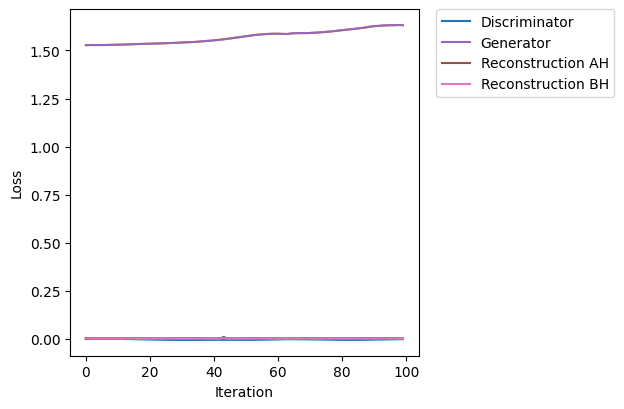

In [26]:
#绘制准确度曲线
fig_curve, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.plot(FD, label="Discriminator")
ax.plot(np.array(FG))
ax.plot(np.array(FG)[:,0], label="Generator")
ax.plot(np.array(FG)[:,1], label="Reconstruction AH")
ax.plot(np.array(FG)[:,2], label="Reconstruction BH")
#ax.set_yscale('log')
plt.ylabel('Loss')
plt.xlabel('Iteration')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.axis('on')
plt.show()

In [40]:
#生成数据
n_viz = 1
BHA_gen = np.array([]); recon_AH = np.array([]); AHB_gen = np.array([]); recon_BH = np.array([]);
for _ in range(n_viz):
    for AH,BH in dataLoader:
        print(AH.device)
        if is_cuda:
            AH=AH.cuda()
            BH=BH.cuda()
        AH,BH=Variable(AH,True),Variable(BH,True)
        #生成BHA
        temp_BHA_gen=GenBHA(AH)
        BHA_gen = np.vstack([BHA_gen, temp_BHA_gen]) if BHA_gen.size else temp_BHA_gen
        #重建数据
        print(BHA_gen)

cuda:0
True
cpu
tensor([[[[-6.5523e-02,  4.2913e+00,  5.8541e-02],
          [-1.6013e-01,  1.0008e+00,  7.0935e+00],
          [ 3.0506e+00,  8.3262e-03,  7.7774e-02],
          ...,
          [-3.3360e-03,  1.9414e-02,  9.3642e-04],
          [-3.3360e-03,  1.9414e-02,  9.3642e-04],
          [-3.3360e-03,  1.9414e-02,  9.3642e-04]],

         [[ 8.9305e-01,  1.1581e+00,  2.9846e+00],
          [ 2.6751e+00,  1.2198e+00,  6.9714e-01],
          [-4.4105e-02,  2.9957e+00,  2.5025e+00],
          ...,
          [-3.3360e-03,  1.9414e-02,  9.3642e-04],
          [-3.3360e-03,  1.9414e-02,  9.3642e-04],
          [-3.3360e-03,  1.9414e-02,  9.3642e-04]],

         [[ 5.2792e-01,  1.4504e-01,  1.2043e+00],
          [ 1.9237e+00,  2.3838e+00,  2.4492e+00],
          [ 1.6268e+00,  8.7654e-01,  6.8425e+00],
          ...,
          [-3.3360e-03,  1.9414e-02,  9.3642e-04],
          [-3.3360e-03,  1.9414e-02,  9.3642e-04],
          [-3.3360e-03,  1.9414e-02,  9.3642e-04]],

         [[-3.3